In [1]:
import cv2, os, datetime
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from imutils import paths
from PIL import Image

pd.set_option('display.max_rows', None)

# import Model
from tensorflow.keras.applications import EfficientNetB1

In [2]:
# DATASET

DATASET_PATH = "C:\\UPJ\\UPJ\\VsCode\\SisDas\\Batik\\DATASET\\DATASET\\TRAIN"
BATCH_SIZE = 30
IMG_SIZE = (500, 500)
INIT_EPOCHS = 15
FINE_TUNE_EPOCHS = 15

# Inilah letaknya folder yang berisi gambar-gambar batik yang akan dipakai belajar komputer.
# Terdapat informasi tentang berapa banyak gambar yang diolah bersamaan (30 gambar),
# berapa besar dimensi gambar (500 x 500 piksel), dan berapa kali belajar (15 kali awal, 15 kali fine-tuning).


In [3]:
# DATA COLLECTION:

train_dataset = image_dataset_from_directory(
    DATASET_PATH,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
    validation_split=0.2,
    subset="training"
)

val_dataset = image_dataset_from_directory(
    DATASET_PATH,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

# Inilah cara kita memuat gambar-gambar dari folder tadi.
# Gambar-gambar ini kemudian diolah untuk menciptakan variasi baru
# seperti memutar, menggeser, dan lainnya agar model belajar lebih baik.

Found 470 files belonging to 4 classes.


Using 376 files for training.
Found 470 files belonging to 4 classes.
Using 94 files for validation.


In [4]:
# DATA COLLECTION:

CLASS_NAMES = train_dataset.class_names
print(CLASS_NAMES)

# Ini adalah nama-nama kelas (jenis batik) yang ada dalam dataset,
# agar kita tahu apa saja yang model akan pelajari.

['Batik Corak Insang', 'Batik Dayak', 'Batik Ikat Celup', 'Batik Megamendung']


In [5]:
# DATA PRE-PROCESSING

img_augmentation = Sequential(
    [
     layers.experimental.preprocessing.RandomRotation(factor=0.15),
     layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomContrast(factor=0.1)
    ],
    name="img_augmentation"
)

# Fungsi ini menciptakan variasi baru dari gambar-gambar kita,
# seperti memutar, menggeser, dan mengubah kontrastnya.

In [6]:
# DATA PRE-PROCESSING

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Buffer-size ini membuat proses loading gambar lebih cepat
# selama proses pelatihan model.

In [7]:
def plot_history(history):
    plt.figure(figsize=(15, 10))
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model Accuracy (Train & Val)")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper center", fontsize=12, bbox_to_anchor=(1.1,1))
    plt.show()
    
# Fungsi ini membuat plot yang menunjukkan seberapa baik model kita belajar.
# Garis-garis pada plot ini memberitahu kita tentang tingkat akurasi pada setiap putaran pelatihan.


In [8]:
# FEATURE EXTRACTION dan FEATURE SELECTION

def build_model(img_size, num_classes):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB1(include_top=False, input_tensor=x, weights="imagenet")

# Fungsi ini membuat model kita dengan menggunakan arsitektur EfficientNetB1,
# yang sudah terlatih menggunakan data dari internet. Model ini kemudian diatur
# agar dapat belajar tugas klasifikasi dari gambar batik yang kita punya.
#------------------------------------------------------------------------------------------

    # Freezing the pretrained weights
    model.trainable = False

    # Sebagian besar bagian dari model ini kita tetapkan agar tidak berubah selama proses pelatihan,
    # supaya tidak kehilangan pengetahuan yang sudah dimiliki oleh model ini.
#------------------------------------------------------------------------------------------

    # Adding new top layers
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.3
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    # Di bagian ini kita menambahkan beberapa lapisan baru di atas model yang sudah ada.
    # Lapisan-lapisan ini membantu kita mengambil informasi yang paling penting dari gambar.
#------------------------------------------------------------------------------------------

    # Compiling the model
    model = tf.keras.Model(inputs, outputs, name="MaskDet-EfficientNetB0")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

    # Model ini sekarang di-compile, atau disiapkan untuk belajar.
    # Kita tentukan bagaimana model ini akan belajar, dengan menggunakan optimizer,
    # loss function, dan metrik yang akan kita pantau selama proses pelatihan.

In [9]:
# VALIDATION (TRAINING/TESTING)

# defining strategy
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = build_model(img_size=500, num_classes=4)
    
# Di sini kita menggunakan strategi pembelajaran yang memanfaatkan lebih dari satu GPU,
# sehingga proses belajar lebih cepat.

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)



In [10]:
# VALIDATION (TRAINING/TESTING)

train_acc_checkpoint = ModelCheckpoint("./eb1_train_acc.h5",
                            monitor="accuracy",
                            save_best_only = True,
                            verbose=1)
val_acc_checkpoint = ModelCheckpoint("./eb1_val_acc.h5",
                            monitor="val_accuracy",
                            save_best_only = True,
                            verbose=1)
callbacks = [train_acc_checkpoint, 
             val_acc_checkpoint]

# Callback ini membuat checkpoint, atau foto, dari model kita
# ketika akurasi pelatihan atau validasi meningkat.

In [11]:
# VALIDATION (TRAINING/TESTING)

hist = model.fit(train_dataset, epochs=INIT_EPOCHS,
                 callbacks=callbacks,
                 validation_data=val_dataset,
                 verbose=2)

# Di sini kita latih model kita dengan data pelatihan dan validasi,
# dan menggunakan callback untuk menyimpan model terbaik.

Epoch 1/15



Epoch 1: accuracy improved from -inf to 0.78989, saving model to .\eb1_train_acc.h5


c:\Users\Razan Aubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: val_accuracy improved from -inf to 0.92553, saving model to .\eb1_val_acc.h5
13/13 - 109s - loss: 0.7070 - accuracy: 0.7899 - val_loss: 0.2250 - val_accuracy: 0.9255 - 109s/epoch - 8s/step
Epoch 2/15

Epoch 2: accuracy improved from 0.78989 to 0.93351, saving model to .\eb1_train_acc.h5

Epoch 2: val_accuracy improved from 0.92553 to 0.93617, saving model to .\eb1_val_acc.h5
13/13 - 95s - loss: 0.2327 - accuracy: 0.9335 - val_loss: 0.1810 - val_accuracy: 0.9362 - 95s/epoch - 7s/step
Epoch 3/15

Epoch 3: accuracy improved from 0.93351 to 0.96809, saving model to .\eb1_train_acc.h5

Epoch 3: val_accuracy improved from 0.93617 to 0.96809, saving model to .\eb1_val_acc.h5
13/13 - 97s - loss: 0.1263 - accuracy: 0.9681 - val_loss: 0.0713 - val_accuracy: 0.9681 - 97s/epoch - 7s/step
Epoch 4/15

Epoch 4: accuracy improved from 0.96809 to 0.97340, saving model to .\eb1_train_acc.h5

Epoch 4: val_accuracy did not improve from 0.96809
13/13 - 97s - loss: 0.1197 - accuracy: 0.9734 - val_

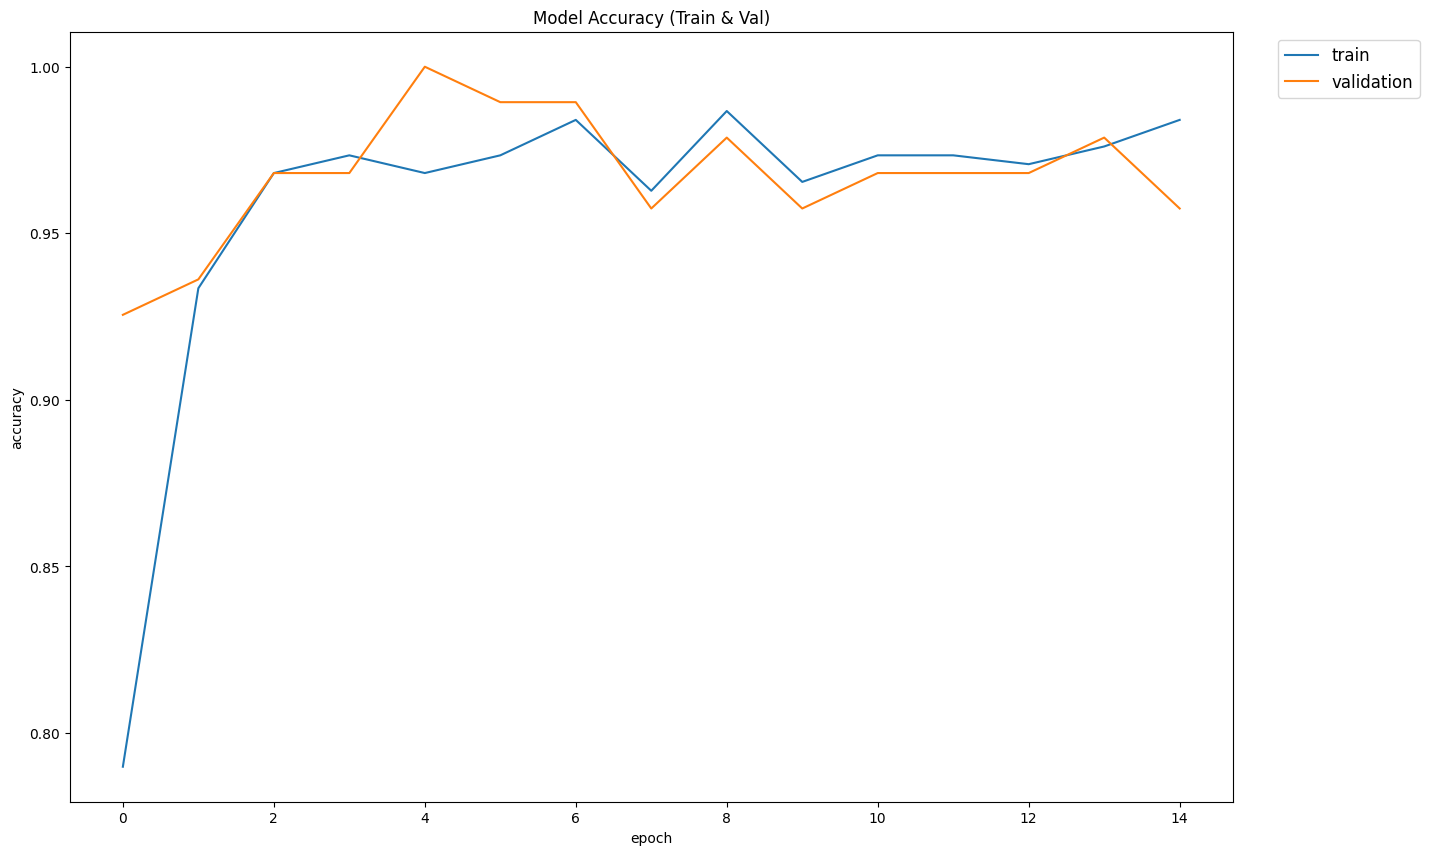

In [12]:
# PROTOTYPE DASHBOARD

plot_history(hist)

# Fungsi ini menunjukkan grafik hasil pelatihan model kita.

In [13]:
# FEATURE SELECTION dan VALIDATION (TRAINING/TESTING)

def unfreezing_model(model, unfreeze_layers):
    for layer in model.layers[unfreeze_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
# Fungsi ini membantu kita untuk membuka kunci beberapa lapisan di model kita
# sehingga kita dapat melatihnya lagi dengan data yang sama (fine-tuning).

In [14]:
# FEATURE SELECTION

unfreezing_model(model, -20)

layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

# Di sini kita membuka kunci beberapa lapisan di model kita,
# kemudian kita lihat apakah lapisan tersebut sudah terbuka atau belum.

,Layer Type,Layer Name,Layer Trainable
0,<keras.src.engine.input_layer.InputLayer objec...,input_1,False
1,<keras.src.engine.sequential.Sequential object...,img_augmentation,False
2,<keras.src.layers.preprocessing.image_preproce...,rescaling,False
3,<keras.src.layers.preprocessing.normalization....,normalization,False
4,<keras.src.layers.preprocessing.image_preproce...,rescaling_1,False
5,<keras.src.layers.reshaping.zero_padding2d.Zer...,stem_conv_pad,False
6,<keras.src.layers.convolutional.conv2d.Conv2D ...,stem_conv,False
7,<keras.src.layers.normalization.batch_normaliz...,stem_bn,False
8,<keras.src.layers.core.activation.Activation o...,stem_activation,False
9,<keras.src.layers.convolutional.depthwise_conv...,block1a_dwconv,False


In [15]:
# VALIDATION (TRAINING/TESTING) FINE TUNNING

train_acc_fine = ModelCheckpoint("./eb1_fine_train_acc.h5",
                            monitor="accuracy",
                            save_best_only = True,
                            verbose=1)
val_acc_fine = ModelCheckpoint("./eb1_fine_val_acc.h5",
                            monitor="val_accuracy",
                            save_best_only = True,
                            verbose=1)

callbacks_finetune = [train_acc_fine,
                      val_acc_fine]

# Di sini kita buat lagi checkpoint baru untuk fase fine-tuning,
# supaya kita bisa membandingkan model terbaik dari fase fine-tuning dengan fase sebelumnya.

In [16]:
# VALIDATION (TRAINING/TESTING) FINE TUNNING

hist_fine_tune = model.fit(train_dataset,
                         epochs=FINE_TUNE_EPOCHS,
                         callbacks=callbacks_finetune,
                         validation_data=val_dataset,
                         verbose=2)

# Di sini kita latih model kita lagi, tapi kali ini kita melatihnya lebih detail lagi
# dengan membuka kunci beberapa lapisan terakhir dan menyimpan model terbaik.

Epoch 1/15

Epoch 1: accuracy improved from -inf to 0.98138, saving model to .\eb1_fine_train_acc.h5


c:\Users\Razan Aubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: val_accuracy improved from -inf to 0.96809, saving model to .\eb1_fine_val_acc.h5
13/13 - 120s - loss: 0.0569 - accuracy: 0.9814 - val_loss: 0.0949 - val_accuracy: 0.9681 - 120s/epoch - 9s/step
Epoch 2/15

Epoch 2: accuracy did not improve from 0.98138

Epoch 2: val_accuracy did not improve from 0.96809
13/13 - 99s - loss: 0.0521 - accuracy: 0.9814 - val_loss: 0.1215 - val_accuracy: 0.9681 - 99s/epoch - 8s/step
Epoch 3/15

Epoch 3: accuracy did not improve from 0.98138

Epoch 3: val_accuracy improved from 0.96809 to 0.97872, saving model to .\eb1_fine_val_acc.h5
13/13 - 99s - loss: 0.0398 - accuracy: 0.9787 - val_loss: 0.1342 - val_accuracy: 0.9787 - 99s/epoch - 8s/step
Epoch 4/15

Epoch 4: accuracy improved from 0.98138 to 0.98936, saving model to .\eb1_fine_train_acc.h5

Epoch 4: val_accuracy did not improve from 0.97872
13/13 - 98s - loss: 0.0636 - accuracy: 0.9894 - val_loss: 0.1777 - val_accuracy: 0.9681 - 98s/epoch - 8s/step
Epoch 5/15

Epoch 5: accuracy improved from 0

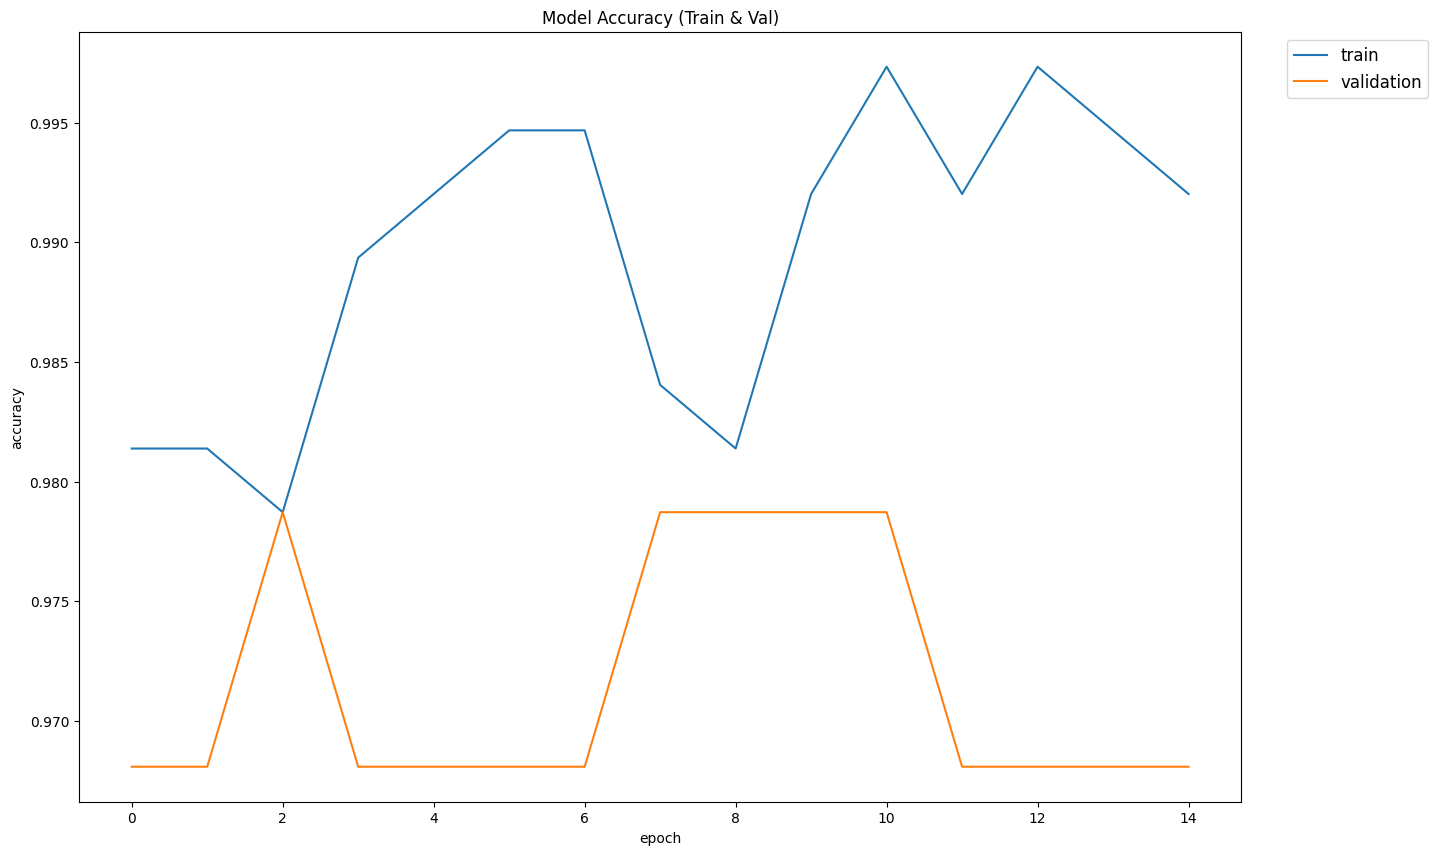

In [18]:
plot_history(hist_fine_tune)


In [17]:
# VALIDATION (TRAINING/TESTING) FINE TUNNING

all_acc = {
    "training": hist.history['accuracy'] + hist_fine_tune.history['accuracy'],
    "validation": hist.history['val_accuracy'] + hist_fine_tune.history['val_accuracy']
}

all_loss = {
    "training": hist.history['loss'] + hist_fine_tune.history['loss'],
    "validation": hist.history['val_loss'] + hist_fine_tune.history['val_loss']
}

print(all_acc)
print(all_loss)

# Akhirnya, kita gabungkan hasil akurasi dan loss dari kedua fase pelatihan
# untuk mendapatkan gambaran akhir dari performa model kita.

{'training': [0.789893627166748, 0.9335106611251831, 0.9680851101875305, 0.9734042286872864, 0.9680851101875305, 0.9734042286872864, 0.9840425252914429, 0.9627659320831299, 0.9867021441459656, 0.9654255509376526, 0.9734042286872864, 0.9734042286872864, 0.9707446694374084, 0.9760638475418091, 0.9840425252914429, 0.9813829660415649, 0.9813829660415649, 0.978723406791687, 0.9893617033958435, 0.9920212626457214, 0.9946808218955994, 0.9946808218955994, 0.9840425252914429, 0.9813829660415649, 0.9920212626457214, 0.9973404407501221, 0.9920212626457214, 0.9973404407501221, 0.9946808218955994, 0.9920212626457214], 'validation': [0.9255319237709045, 0.936170220375061, 0.9680851101875305, 0.9680851101875305, 1.0, 0.9893617033958435, 0.9893617033958435, 0.957446813583374, 0.978723406791687, 0.957446813583374, 0.9680851101875305, 0.9680851101875305, 0.9680851101875305, 0.978723406791687, 0.957446813583374, 0.9680851101875305, 0.9680851101875305, 0.978723406791687, 0.9680851101875305, 0.968085110187